In [1]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve, average_precision_score
from mpl_toolkits.axes_grid1 import make_axes_locatable


def set_global_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

# set random seed
set_global_seed(42)

# Loading data

In [67]:
df_g1 = pd.read_excel('DATA.xlsx', sheet_name='group1')
df_g2 = pd.read_excel('DATA.xlsx', sheet_name='group2')
df_g3 = pd.read_excel('DATA.xlsx', sheet_name='group3')

In [68]:
df_g1.columns

Index(['Deposit', 'SiO2', 'TiO2', 'Al2O3', 'TFe2O3', 'MnO', 'MgO', 'CaO',
       'Na2O', 'K2O', 'P2O5', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Ba', 'La', 'Ce',
       'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
       'Hf', 'Ta', 'Th', 'U'],
      dtype='object')

In [69]:
element_list = [
    'SiO2', 'TiO2', 'Al2O3', 'TFe2O3', 'MnO', 'MgO', 'CaO',
   'Na2O', 'K2O', 'P2O5', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Ba', 'La', 'Ce',
   'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
   'Hf', 'Ta', 'Th', 'U'
    ]
all_list = [
    'class', 'SiO2', 'TiO2', 'Al2O3', 'TFe2O3', 'MnO', 'MgO', 'CaO',
    'Na2O', 'K2O', 'P2O5', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Ba', 'La', 'Ce',
    'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
    'Hf', 'Ta', 'Th', 'U'
    ]
# Add a 'class' column to each dataframe
df_g1['class'] = 0
df_g2['class'] = 1
df_g3['class'] = 2


# Concatenate the dataframes
df = pd.concat([df_g1[all_list], df_g2[all_list], df_g3[all_list]])


df = df.replace('na', pd.NaT)

df = df.dropna()
cols = df.columns.drop('class')
df[cols] = df[cols].astype('float64')

In [70]:
df

,class,SiO2,TiO2,Al2O3,TFe2O3,MnO,MgO,CaO,Na2O,K2O,...,Dy,Ho,Er,Tm,Yb,Lu,Hf,Ta,Th,U
0,0,71.020700,0.173346,10.716835,9.279892,0.040787,0.907515,0.458856,0.785153,6.801264,...,1.61,0.330,0.90,0.130,0.87,0.13,2.92,0.21,10.80,2.16
1,0,69.453141,0.292215,14.683782,4.936078,0.093926,1.137550,1.012315,1.001879,7.472344,...,1.66,0.330,0.92,0.140,0.91,0.14,4.05,0.56,21.50,4.23
2,0,67.341486,0.308293,14.643921,5.816237,0.051382,1.335937,1.839482,2.743808,5.950057,...,2.21,0.460,1.35,0.210,1.40,0.22,4.20,0.64,19.30,6.66
3,0,62.751540,0.595483,16.139630,5.830195,0.123203,2.720739,4.117043,3.459959,4.291581,...,3.65,0.740,2.04,0.320,2.09,0.32,5.14,0.85,19.50,6.73
4,0,62.168551,0.596095,16.187050,5.806516,0.102775,2.795478,4.552929,3.854060,3.946557,...,3.59,0.710,1.97,0.300,1.89,0.29,5.01,0.78,19.30,6.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,2,64.797444,0.391712,17.369343,5.288115,0.092774,1.865787,5.154108,4.319142,0.505103,...,2.26,0.439,1.25,0.232,1.49,0.23,1.56,0.14,1.43,0.73
63,2,64.547403,0.459231,17.062966,5.969997,0.132667,2.061435,5.143382,3.796306,0.571487,...,2.57,0.477,1.35,0.229,1.54,0.24,2.24,0.20,1.98,1.02
64,2,64.525901,0.363526,17.126123,5.483187,0.151469,1.736847,5.907301,4.180551,0.323134,...,2.13,0.410,1.22,0.190,1.37,0.24,1.70,0.20,1.76,0.78
65,2,65.021199,0.434080,16.787805,5.017161,0.181708,1.716132,5.521906,4.855643,0.222088,...,2.44,0.480,1.39,0.210,1.40,0.23,2.30,0.20,2.19,0.74


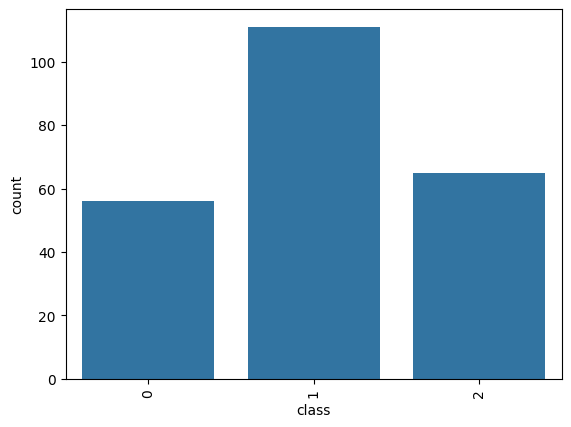

In [8]:
fig,ax = plt.subplots()
sns.countplot(x='class', data= df)
plt.xticks(rotation=90)
plt.show()

In [9]:
df.dtypes

class       int64
SiO2      float64
TiO2      float64
Al2O3     float64
TFe2O3    float64
MnO       float64
MgO       float64
CaO       float64
Na2O      float64
K2O       float64
P2O5      float64
Rb        float64
Sr        float64
Y         float64
Zr        float64
Nb        float64
Ba        float64
La        float64
Ce        float64
Pr        float64
Nd        float64
Sm        float64
Eu        float64
Gd        float64
Tb        float64
Dy        float64
Ho        float64
Er        float64
Tm        float64
Yb        float64
Lu        float64
Hf        float64
Ta        float64
Th        float64
U         float64
dtype: object

In [17]:
# Split data into X_train and y
X_train = df.drop('class', axis=1)
y = df['class']

# Split data into train and test sets
X_train_train, X_train_test, y_train, y_test = train_test_split(X_train, y, test_size=0.4, random_state=42)

# Redefine the hyperparameter space
xgb_params = {
    'eta': Real(0.01, 1.0, 'log-uniform'),
    'min_child_weight': Real(1, 10),
    'max_depth': Integer(0, 50),
    'max_delta_step': (0, 20),
    'subsample': Real(0.1, 1.0, 'uniform'),
    # 'colsample_bytree': (0.01, 1.0, 'uniform'),
    # 'colsample_bylevel': (0.01, 1.0, 'uniform'),
    # 'reg_lambda': (1e-9, 1000, 'log-uniform'),
    # 'reg_alpha': (1e-9, 1.0, 'log-uniform'),
    'gamma': Real(1e-9, 0.5, 'log-uniform'),
    'min_child_weight': Real(0.5, 5),
    'n_estimators': Integer(50, 100),
    # 'scale_pos_weight': (1e-6, 500, 'log-uniform')
}

# Define the parameter space for RandomForest
rf_params = {
    'n_estimators': Integer(10, 200),
    'max_depth': Integer(1, 50),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf': Integer(1, 5)
}


# Initialize BayesSearchCV objects for X_trainGBoost and RandomForest
xgb_search = BayesSearchCV(XGBClassifier(), xgb_params, n_iter=50, cv=3, n_jobs=-1)
rf_search = BayesSearchCV(RandomForestClassifier(), rf_params, n_iter=50, cv=3, n_jobs=-1)

# Fit the models
xgb_search.fit(X_train_train, y_train)
rf_search.fit(X_train_train, y_train)

# Print the best parameters and score
print("X_trainGBoost Best Parameters: ", xgb_search.best_params_)
print("X_trainGBoost Best Score: ", xgb_search.best_score_)
print("RandomForest Best Parameters: ", rf_search.best_params_)
print("RandomForest Best Score: ", rf_search.best_score_)

X_trainGBoost Best Parameters:  OrderedDict([('eta', 0.37762219108251793), ('gamma', 4.1275871548467575e-06), ('max_delta_step', 20), ('max_depth', 26), ('min_child_weight', 0.5), ('n_estimators', 50), ('subsample', 0.5169612949661923)])
X_trainGBoost Best Score:  0.8780450200431699
RandomForest Best Parameters:  OrderedDict([('max_depth', 36), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 117)])
RandomForest Best Score:  0.8925377736663583


In [18]:
print(xgb_search.score(X_train_test, y_test))
print(rf_search.score(X_train_test, y_test))

0.8387096774193549
0.9139784946236559


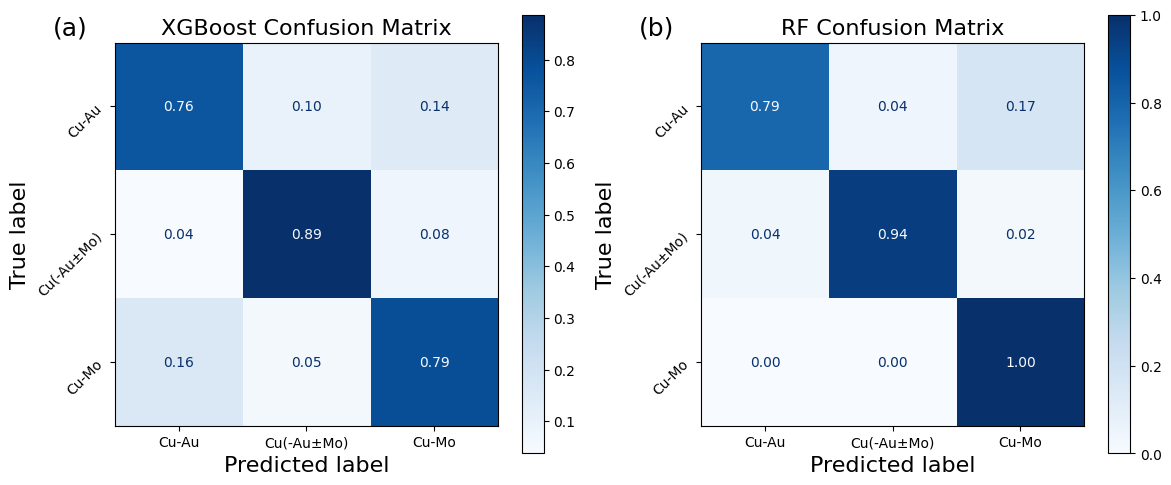

In [128]:
custom_labels = ['Cu-Au', 'Cu(-Au±Mo)', 'Cu-Mo']

# Initialize subplot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


# XGBoost的混淆矩阵
ncm_xgb = ConfusionMatrixDisplay.from_predictions(
    xgb_search.predict(X_train_test),
    y_test,
    normalize='true',
    values_format='.2f',
    display_labels=custom_labels,
    ax=axs[0],
    cmap='Blues',
)
axs[0].set_title('XGBoost Confusion Matrix', fontsize=16)
axs[0].set_xlabel('Predicted label', fontsize=16, )
axs[0].set_ylabel('True label', fontsize=16)
axs[0].annotate('(a)', xy=(-0.07, 1.07), xycoords='axes fraction', fontsize=18, 
#                 fontweight='bold', 
                ha='right', va='top', annotation_clip=False)
# axs[0].tick_params(axis='x', labelrotation=45)
axs[0].tick_params(axis='y', labelrotation=45)


# RF的混淆矩阵
ncm_rf = ConfusionMatrixDisplay.from_predictions(
    rf_search.predict(X_train_test),
    y_test,
    normalize='true',
    values_format='.2f',
    display_labels=custom_labels,
    ax=axs[1],
    cmap='Blues',
)
axs[1].set_title('RF Confusion Matrix', fontsize=16)
axs[1].set_xlabel('Predicted label', fontsize=16, )
axs[1].set_ylabel('True label', fontsize=16)
axs[1].annotate('(b)', xy=(-0.07, 1.07), xycoords='axes fraction', fontsize=18, 
#                 fontweight='bold', 
                ha='right', va='top', annotation_clip=False)
# axs[1].tick_params(axis='x', labelrotation=45)
axs[1].tick_params(axis='y', labelrotation=45)



plt.tight_layout()
plt.savefig("2024-confusionmatrix-0510.pdf")
plt.show()


## Precision-recall curve

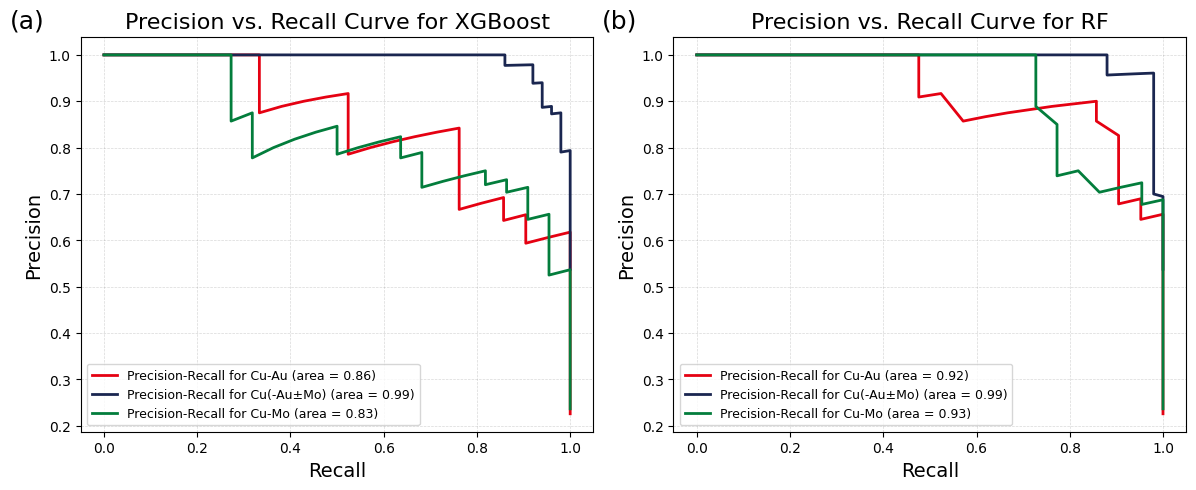

In [124]:
# Define custom label names
custom_labels = ['Cu-Au', 'Cu(-Au±Mo)', 'Cu-Mo']
# Define custom colors for plots
colors = ['#E50112', '#1A2650', '#037D3C']

# Assuming xgb_search, rf_search, X_train_test, and y_test are already defined
# One-hot encode the target variable
enc = OneHotEncoder()
enc.fit(y_test.array.reshape(-1, 1))
enc_y_test = enc.transform(y_test.array.reshape(-1, 1)).toarray()

# Get prediction probabilities from XGBoost
y_score_xgb = xgb_search.predict_proba(X_train_test)
# Get prediction probabilities from Random Forest
y_score_rf = rf_search.predict_proba(X_train_test)

# Initialize dictionaries for precision, recall, and average precision for XGBoost
precision_xgb = dict()
recall_xgb = dict()
average_precision_xgb = dict()

# Initialize dictionaries for precision, recall, and average precision for Random Forest
precision_rf = dict()
recall_rf = dict()
average_precision_rf = dict()

# Number of classes
n_classes = 3

# Initialize subplot layout
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Precision-Recall curve for XGBoost
labels_xgb = []
for i in range(n_classes):
    precision_xgb[i], recall_xgb[i], _ = precision_recall_curve(enc_y_test[:, i], y_score_xgb[:, i])
    average_precision_xgb[i] = average_precision_score(enc_y_test[:, i], y_score_xgb[:, i])
    axs[0].plot(recall_xgb[i], precision_xgb[i], lw=2, color=colors[i])
    labels_xgb.append('Precision-Recall for {0} (area = {1:0.2f})'.format(custom_labels[i], average_precision_xgb[i]))

axs[0].set_xlabel("Recall", fontsize=14)
axs[0].set_ylabel("Precision", fontsize=14)
axs[0].legend(labels_xgb, loc="best", fontsize=9)
axs[0].set_title("Precision vs. Recall Curve for XGBoost", fontsize=16)
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
axs[0].annotate('(a)', xy=(-0.07, 1.07), xycoords='axes fraction', fontsize=18, ha='right', va='top', annotation_clip=False)

# Plot Precision-Recall curve for Random Forest
labels_rf = []
for i in range(n_classes):
    precision_rf[i], recall_rf[i], _ = precision_recall_curve(enc_y_test[:, i], y_score_rf[:, i])
    average_precision_rf[i] = average_precision_score(enc_y_test[:, i], y_score_rf[:, i])
    axs[1].plot(recall_rf[i], precision_rf[i], lw=2, color=colors[i])
    labels_rf.append('Precision-Recall for {0} (area = {1:0.2f})'.format(custom_labels[i], average_precision_rf[i]))

axs[1].set_xlabel("Recall", fontsize=14)
axs[1].set_ylabel("Precision", fontsize=14)
axs[1].legend(labels_rf, loc="best", fontsize=9)
axs[1].set_title("Precision vs. Recall Curve for RF", fontsize=16)
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)
axs[1].annotate('(b)', xy=(-0.07, 1.07), xycoords='axes fraction', fontsize=18, ha='right', va='top', annotation_clip=False)

# Save the figure as a PDF file
plt.savefig("2024-percision vs recall curve-0510.pdf")
plt.tight_layout()
plt.show()


## SHAP

[16:29:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


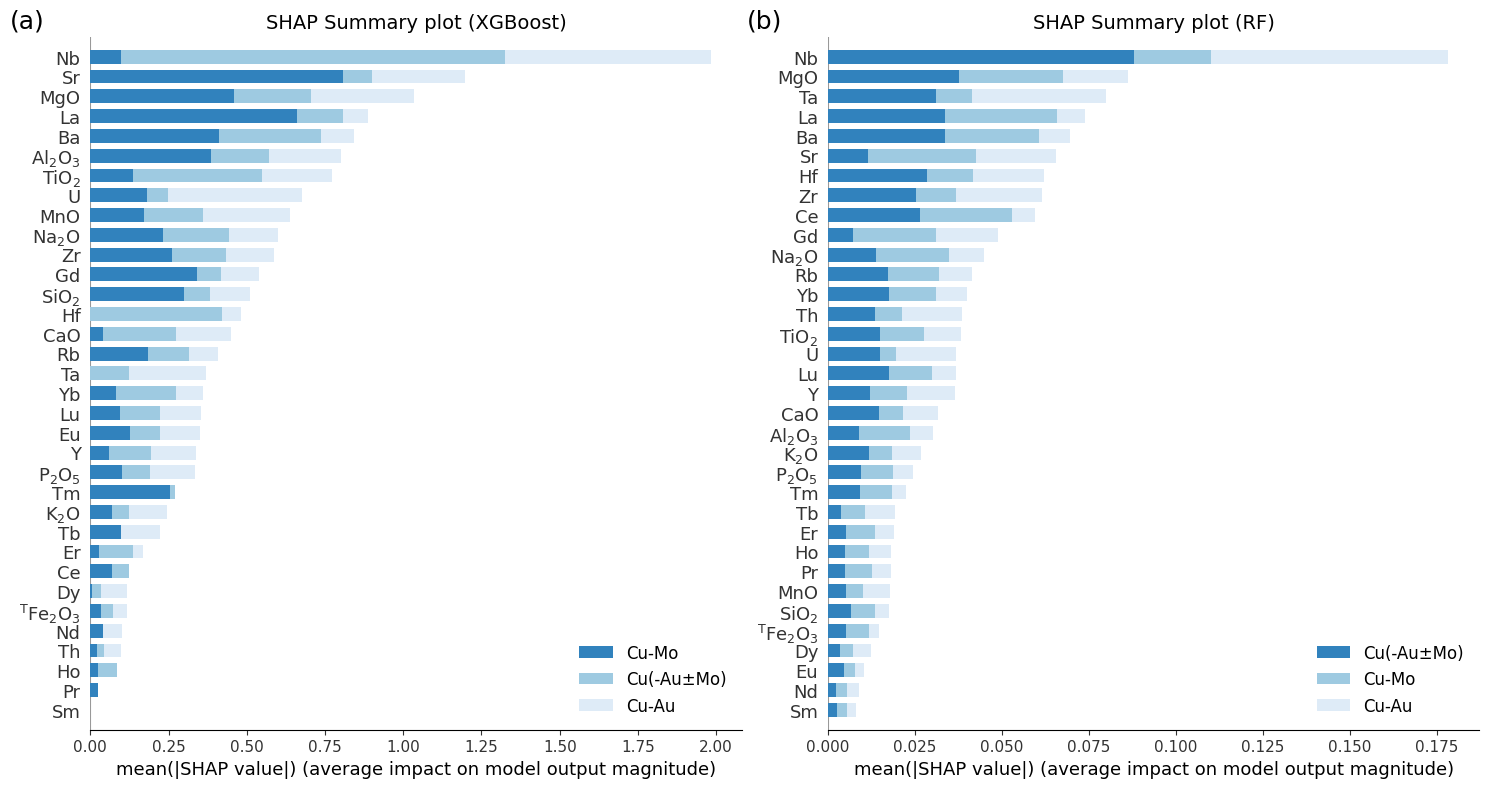

In [126]:
import shap
from matplotlib.colors import LinearSegmentedColormap

# Function to convert chemical formulae to display-friendly format with subscripts for numbers and proper formatting for isotopes
def format_chemical_formula(formula):
    return (formula.replace("2", "$_2$")
                   .replace("3", "$_3$")
                   .replace("4", "$_4$")
                   .replace("5", "$_5$")
                   .replace("TFe", "$^{\\mathrm{T}}$Fe"))

# Apply formatting to the elements in the list
features = np.array([format_chemical_formula(f) for f in element_list])

# Initialize SHAP TreeExplainer for XGBoost and Random Forest models
xgb_explainer = shap.TreeExplainer(xgb_search.best_estimator_)
rf_explainer = shap.TreeExplainer(rf_search.best_estimator_)

# Calculate SHAP values for both models
xgb_shap_values = xgb_explainer.shap_values(X_train)
rf_shap_values = rf_explainer.shap_values(X_train)

# Define three shades of blue for visualization
blue_colors = ['#3182bd', '#9ecae1', '#deebf7']  # Light blue, medium blue, dark blue

# Create a custom color map with defined blue shades
cmap = LinearSegmentedColormap.from_list('custom_blue', blue_colors, N=len(blue_colors))

# Set the figure size for the plots
plt.figure(figsize=(12, 8))

# Plot SHAP summary plot for XGBoost model's feature importance
plt.subplot(1, 2, 1)
shap.summary_plot(xgb_shap_values, X_train, class_names=custom_labels, feature_names=features, plot_type="bar", color=cmap, max_display=100, show=False, plot_size=(10,8))
plt.title("SHAP Summary plot (XGBoost)", fontsize=18)
plt.annotate('(a)', xy=(-0.07, 1.04), xycoords='axes fraction', fontsize=18, ha='right', va='top', annotation_clip=False)

# Plot SHAP summary plot for Random Forest model's feature importance
plt.subplot(1, 2, 2)
shap.summary_plot(rf_shap_values, X_train, class_names=custom_labels, feature_names=features, plot_type="bar", color=cmap, max_display=100, show=False, plot_size=(15,8))
plt.title("SHAP Summary plot (RF)", fontsize=18)
plt.annotate('(b)', xy=(-0.07, 1.04), xycoords='axes fraction', fontsize=18, ha='right', va='top', annotation_clip=False)

# Adjust layout to fit everything neatly
# plt.tight_layout()
plt.savefig("2024-shap_importance-0510.pdf")
plt.show()


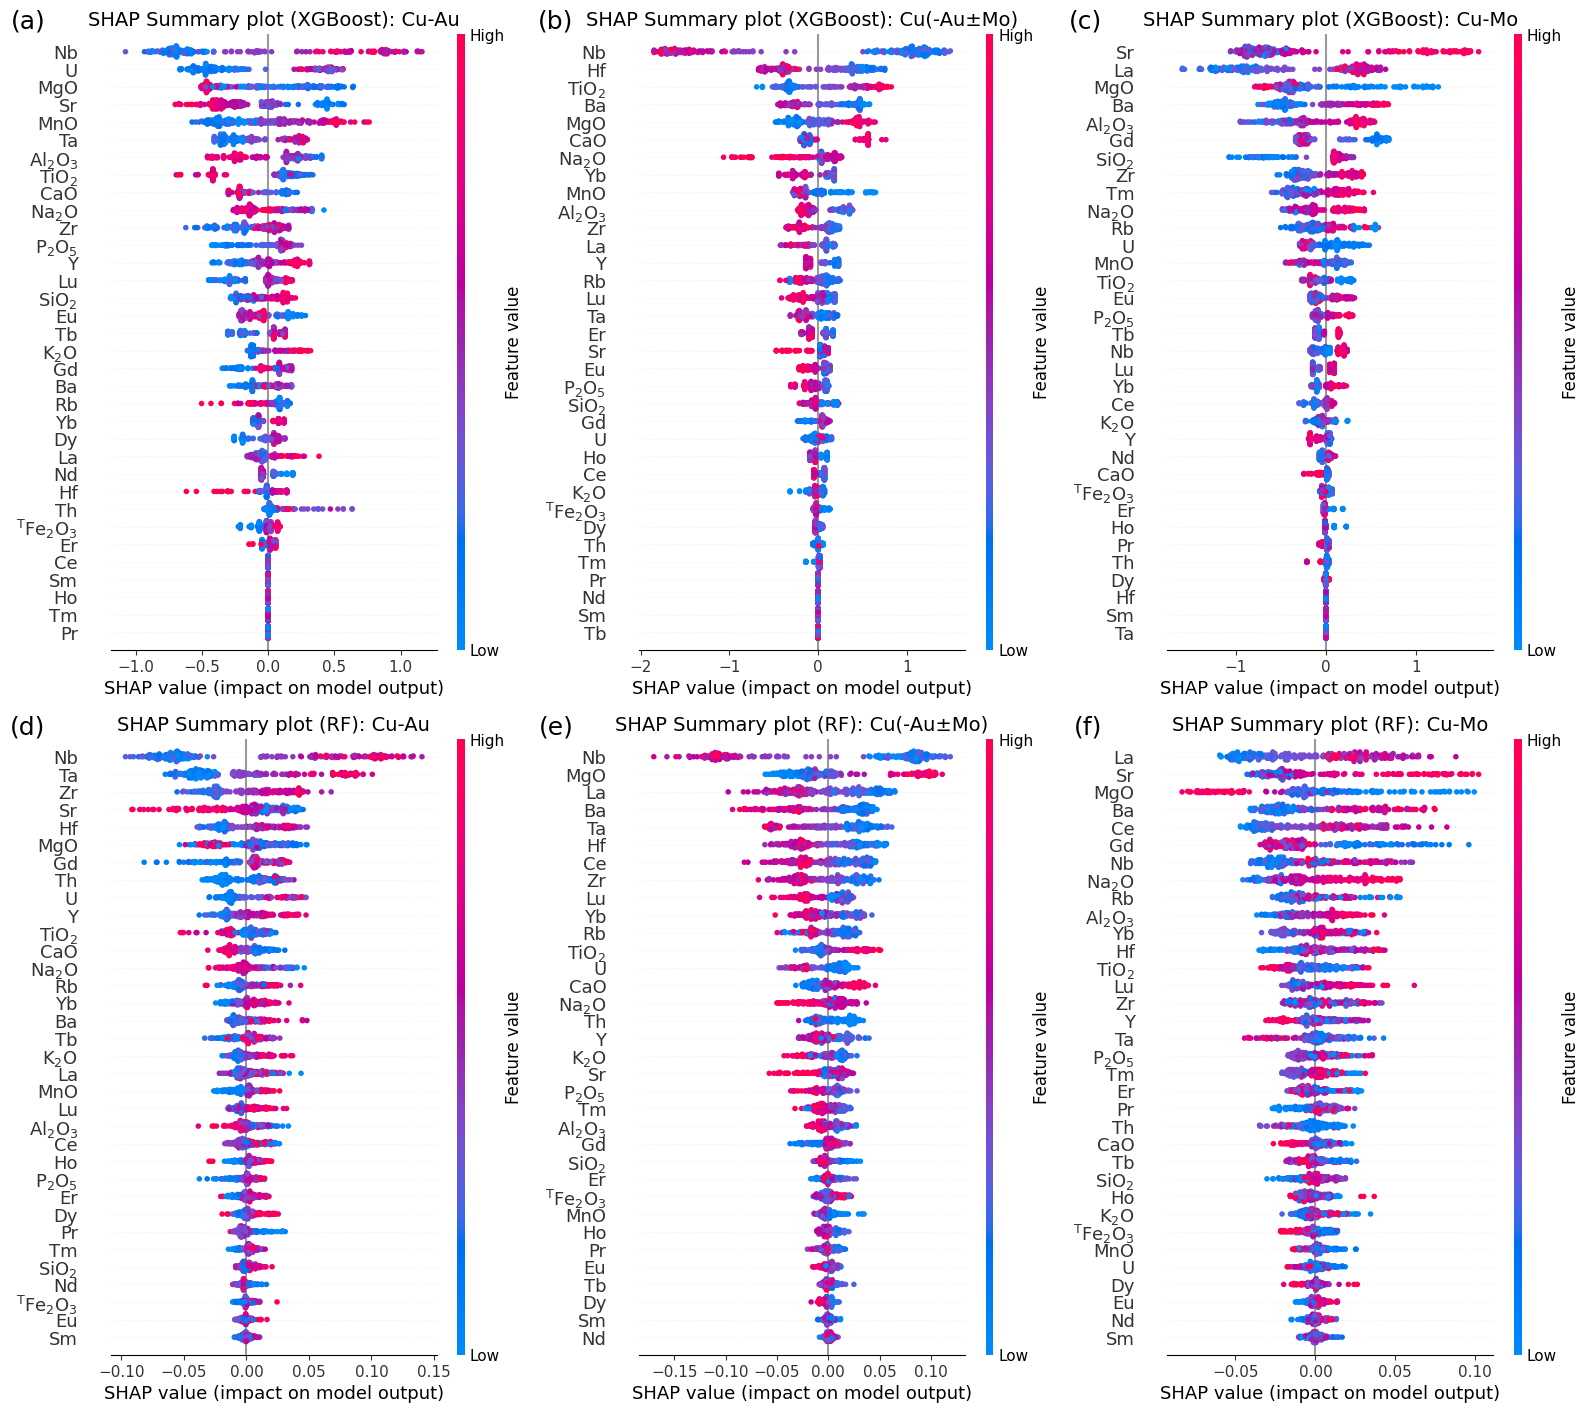

In [127]:
annotate_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Initialize a subplot layout with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(12, 12))

# Plot SHAP dot plots for XGBoost for each class
for i in range(3):
    plt.sca(axs[0, i])
    shap.summary_plot(
        xgb_shap_values[i], X_train,
        plot_type="dot",  # Dot plot type for visualizing feature impacts
        show=False,  # Prevent automatic display of the plot
        feature_names=features,  # Use formatted feature names
        plot_size=(16, 15),  # Adjust plot size to fit in subplots
        max_display=100  # Limit features displayed to the top 100
    )
    axs[0, i].set_title("SHAP Summary plot (XGBoost): " + custom_labels[i], fontsize=18)  # Set subplot title
    axs[0, i].annotate(annotate_labels[i], xy=(-0.2, 1.04), xycoords='axes fraction', fontsize=18, ha='right', va='top', annotation_clip=False)  # Annotate subplot for easier identification

# Plot SHAP dot plots for Random Forest for each class
for i in range(3):
    plt.sca(axs[1, i])
    shap.summary_plot(
        rf_shap_values[i], X_train,
        plot_type="dot",  # Dot plot type for visualizing feature impacts
        show=False,  # Prevent automatic display of the plot
        feature_names=features,  # Use formatted feature names
        plot_size=(16, 15),  # Adjust plot size to fit in subplots
        max_display=100  # Limit features displayed to the top 100
    )
    axs[1, i].set_title("SHAP Summary plot (RF): " + custom_labels[i], fontsize=18)  # Set subplot title
    axs[1, i].annotate(annotate_labels[3 + i], xy=(-0.2, 1.04), xycoords='axes fraction', fontsize=18, ha='right', va='top', annotation_clip=False)  # Annotate subplot for easier identification

# Adjust overall layout to fit subplots nicely
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("2024-shap summary individual-0510.pdf")  # Save the figure to a PDF file
plt.show()  # Display the plots
